In [2]:
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

## Support Vector Machines

In [4]:
df = pd.read_csv("data/prepared_data.csv")

In [5]:
df.shape

(255082, 10)

In [6]:
df['DocumentType'].unique()

array(['Review', 'Tweet'], dtype=object)

In [7]:
df.head()

,DocumentID,Text,Label,LabelType,LabelName,DocumentType,LengthCharacters,HasEmoji,cleaned_text,LabelMapped
0,1,"Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.",1,StarRating,1 Star,Review,612,0,arrived broken manufacturer defect two of the legs of the base were not completely formed so there was no way to insert the casters i unpackaged the entire chair and hardware before noticing this so ill spend twice the amount of time boxing up the whole useless thing and send it back with a star review of part of a chair i never got to sit in i will go so far as to include a picture of what their injection molding and quality assurance process missed though i will be hesitant to buy again it makes me wonder if there arent missing structures and supports that dont impede the assembly process,-1
1,2,the cabinet dot were all detached from backing... got me,1,StarRating,1 Star,Review,56,0,the cabinet dot were all detached from backing got me,-1
2,3,I received my first order of this product and it was broke so I ordered it again. The second one was broke in more places than the first. I can't blame the shipping process as it's shrink wrapped and boxed.,1,StarRating,1 Star,Review,206,0,i received my first order of this product and it was broke so i ordered it again the second one was broke in more places than the first i cant blame the shipping process as its shrink wrapped and boxed,-1
3,4,"This product is a piece of shit. Do not buy. Doesn't work, and then I try to call for customer support, it won't take my number. Fucking rip off!",1,StarRating,1 Star,Review,145,0,this product is a piece of shit do not buy doesnt work and then i try to call for customer support it wont take my number fucking rip off,-1
4,5,went through 3 in one day doesn't fit correct and couldn't get bubbles out (better without),1,StarRating,1 Star,Review,91,0,went through in one day doesnt fit correct and couldnt get bubbles out better without,-1


## 1. First attempt without any optimisations

### 1.1 Prepare data

In [8]:
X = df['cleaned_text']
y = df['LabelMapped']

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /home/mja227/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mja227/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1.2.1 Vectorize text

In [10]:
X_processed = [preprocess_text(i) for i in X]
vectorizer = TfidfVectorizer()

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

X_tfidf = tfidf_vectorizer.fit_transform(X_processed)

print("Shape of TF-IDF matrix:", X_tfidf.shape)

Shape of TF-IDF matrix: (255082, 5000)


### 1.2.2 Feauture Selection

In [11]:
chi2_selector = SelectKBest(chi2, k=100)
X_kselect = chi2_selector.fit_transform(X_tfidf, y)

feature_sums = np.array(X_kselect.sum(axis=0)).flatten()
k=5
top_k_indices = np.argsort(feature_sums)[-k:]

X_kbest = X_kselect[:, top_k_indices]

In [12]:
print(X_kbest.nnz)

110558


### 1.3.1 Train a model 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size=0.2, random_state=42)

### 1.3.2 Grid Search

In [12]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1]  # gamma is relevant for 'rbf' kernel
}

svm_model = SVC()

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ......................C=0.1, gamma=0.1, kernel=rbf; total time=122.1min
[CV] END ......................C=1, gamma=0.001, kernel=rbf; total time=139.8min
[CV] END ......................C=1, gamma=0.001, kernel=rbf; total time=141.0min
[CV] END .....................C=0.1, gamma=0.01, kernel=rbf; total time=141.0min
[CV] END .....................C=0.1, gamma=0.01, kernel=rbf; total time=141.1min
[CV] END .....................C=0.1, gamma=0.01, kernel=rbf; total time=141.2min
[CV] END ......................C=1, gamma=0.001, kernel=rbf; total time=141.6min
[CV] END ....................C=0.1, gamma=0.001, kernel=rbf; total time=164.8min
[CV] END ....................C=0.1, gamma=0.001, kernel=rbf; total time=166.1min
[CV] END ....................C=0.1, gamma=0.001, kernel=rbf; total time=166.5min
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=97.6min
[CV] END .........................C=1, gamma=0.1

In [13]:
# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters found:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.67


In [15]:
%%time 
best_svm_model = SVC(C=1, kernel='rbf', gamma=0.1)
best_svm_model.fit(X_train, y_train)

CPU times: user 37min 15s, sys: 4.27 s, total: 37min 19s
Wall time: 37min 28s


SVC(C=1, gamma=0.1)

### 1.4 Evaluate the model

In [17]:
%%time
y_pred = best_svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.41      0.88      0.56     17993
           0       0.00      0.00      0.00     12600
           1       0.66      0.38      0.48     20424

    accuracy                           0.46     51017
   macro avg       0.35      0.42      0.35     51017
weighted avg       0.41      0.46      0.39     51017

CPU times: user 3min 40s, sys: 146 ms, total: 3min 40s
Wall time: 3min 41s


/opt/conda/envs/dspt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/dspt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/dspt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           Predicted -1  Predicted 0  Predicted 1
Actual -1         15906            0         2087
Actual 0          10634            0         1966
Actual 1          12662            0         7762


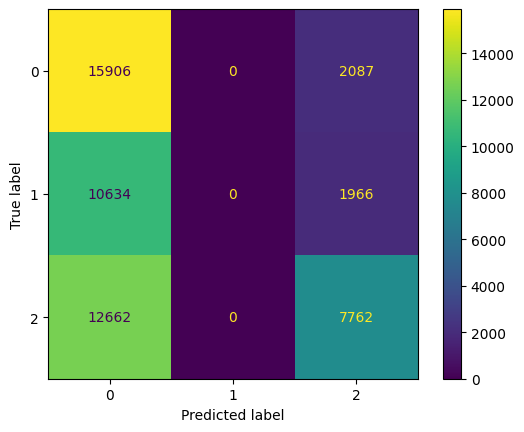

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual -1', 'Actual 0', 'Actual 1'], columns=['Predicted -1', 'Predicted 0', 'Predicted 1'])
print(cm_df)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

## 2. Let's try to look for most optimal hyperparams
We simply take a few options of hyperparams and see what combination gives best accuracy.

Hyperparams:
- tfidf__max_df: Controls the removal of very frequent terms.
- tfidf__ngram_range: Controls the inclusion of unigrams and bigrams.
- nb__alpha: Controls the amount of smoothing in the Naive Bayes classifier.

Lookup takes 2x2x3=12 times longer than training of the single model.
So expect this code to run around 10 minutes.

### 2.1 Create pipeline for hyperparameters search

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

param_grid = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

### 2.2 Search for most optimal hyperparams

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
# Print best parameters
print(grid_search.best_params_)

### 2.3 Predict the results using model with most optimal hyperparams

In [ ]:
best_params = grid_search.best_params_

# Create a new pipeline with the best parameters
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=best_params['tfidf__max_df'], 
                              ngram_range=best_params['tfidf__ngram_range'])),
    ('nb', MultinomialNB(alpha=best_params['nb__alpha']))
])

# Fit the final model with the best parameters on the entire training data
final_pipeline.fit(X_train, y_train)

# Now you can use final_pipeline to predict new data
y_pred = final_pipeline.predict(X_test)

### 2.4 Evaluate the model

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual -1', 'Actual 0', 'Actual 1'], columns=['Predicted -1', 'Predicted 0', 'Predicted 1'])
print(cm_df)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

## 3. Add columns LengthCharacters and HasEmoji to the model

### 3.1 Create column extractor

In [ ]:
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.column_name].values.reshape(-1, 1)

### 3.2 ColumnTransformer will allow us to get values from extra columns

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_df=0.75, ngram_range=(1,2)), 'cleaned_text'),
        ('has_emoji', ColumnExtractor('HasEmoji'), ['HasEmoji']),
        ('length_characters', ColumnExtractor('LengthCharacters'), ['LengthCharacters'])
    ]
)

### 3.3 Predict

In [ ]:
X = df[['cleaned_text', 'HasEmoji', 'LengthCharacters']]
y = df['LabelMapped']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the final pipeline
pipeline = Pipeline([
    ('features', preprocessor),
    ('nb', MultinomialNB(alpha=0.1))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict and evaluate on test data
y_pred = pipeline.predict(X_test)

### 3.4 Evaluate 

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual -1', 'Actual 0', 'Actual 1'], columns=['Predicted -1', 'Predicted 0', 'Predicted 1'])
print(cm_df)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()